# Comparing a USGSCSM and ISIS camera for MRO CTX

In [1]:
import os 

os.environ["ISISROOT"] = "/usgs/cpkgs/anaconda3_linux/envs/isis3.7.0"

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mro_drivers import MroCtxPds3LabelNaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

/home/acpaquette/repos/ale/ale/__init__.py:22: UserWarning:

ALESPICEROOT environment variable not set, Spice Drivers will not function correctly



## Download Image

In [2]:
url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

!wget -N -P data/ {url}
fileName = 'data/' + os.path.split(url)[1]

--2020-02-12 17:42:35--  https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG
Resolving pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)... 137.78.251.82
Connecting to pds-imaging.jpl.nasa.gov (pds-imaging.jpl.nasa.gov)|137.78.251.82|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/K11_057871_1602_XN_19S163W.IMG’ not modified on server. Omitting download.



## Ingest the image into ISIS and attach ALE spice via spiceinit

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

try: 
    isis.mroctx2isis(from_=fileName, to=cub_loc)
except ProcessError as e:
    print(e.stderr)

try:
    isis.spiceinit(from_=cub_loc, shape='ellipsoid')
except ProcessError as e:
    print(e.stderr)

## Create an ISD from the PDS3 .IMG using ISIS cube kernels and store it next to the cube

In [4]:
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)

csm_isd = os.path.splitext(cub_loc)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)
    
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

In [5]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

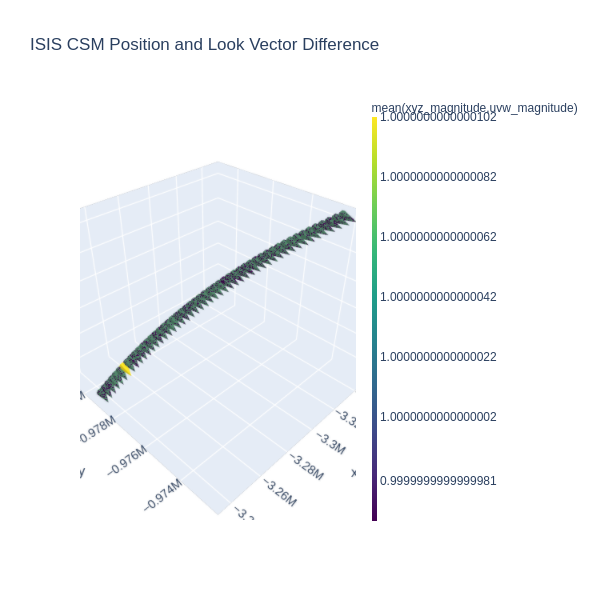

In [6]:
Image(csmisis_diff_lv_plot.to_image())

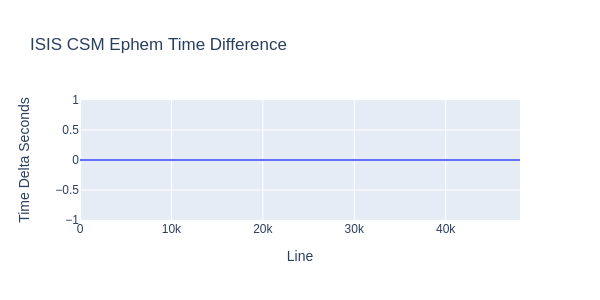

In [7]:
Image(csmisis_diff_ephem_plot.to_image())

In [8]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,0.000013,0.000043,-0.000003,-6.181920e-09,-5.679656e-09,2.038166e-08
std,0.000382,0.000878,0.000142,6.491371e-08,2.082203e-07,1.742555e-07
min,-0.000905,-0.001969,-0.000317,-2.701741e-07,-6.152325e-07,-3.807541e-07
25%,-0.000273,-0.000511,-0.000116,-3.515621e-08,-1.344616e-07,-7.594028e-08
50%,-0.000005,0.000012,0.000003,4.691348e-09,-1.000828e-09,-2.066309e-09
75%,0.000315,0.000709,0.000103,3.005917e-08,9.220612e-08,1.007082e-07
max,0.000899,0.002072,0.000317,1.248720e-07,5.377268e-07,4.886410e-07


In [9]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600, edge_pad=0.01)

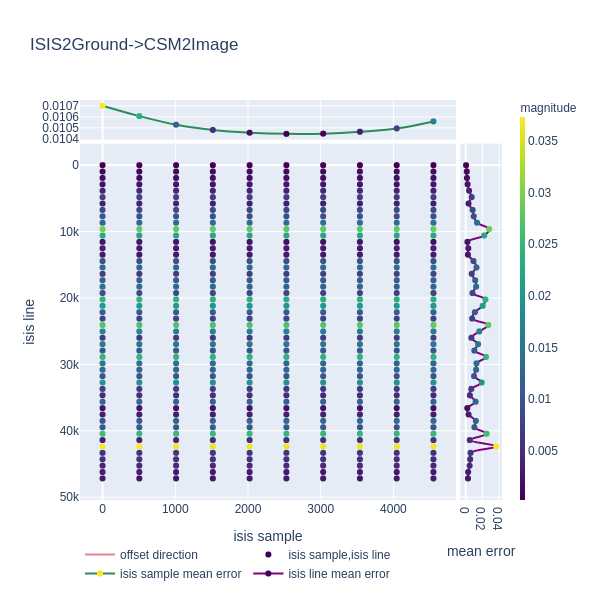

In [10]:
Image(isis2csm_plot.to_image())

In [11]:
isis2csm_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,0.000654,0.000296
std,0.007469,0.011021
min,-0.014820,-0.028769
25%,-0.003767,-0.004859
50%,-0.000044,-0.000055
75%,0.004241,0.006640
max,0.023690,0.033103


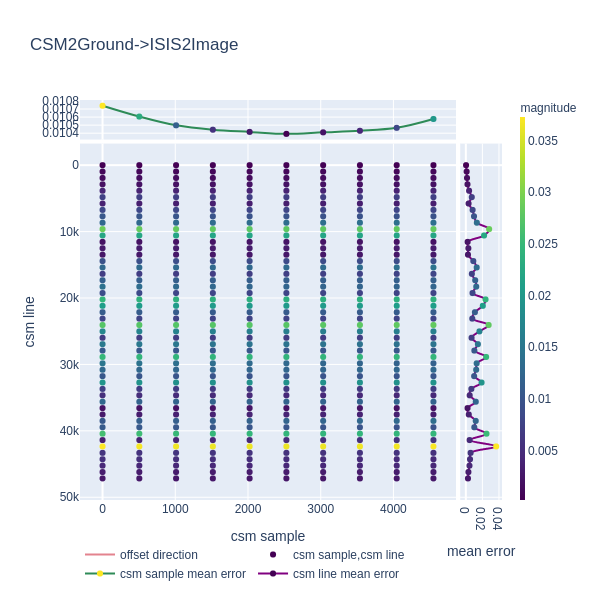

In [12]:
Image(csm2isis_plot.to_image())

In [13]:
csm2isis_data[['diff line', 'diff sample']].describe()

,diff line,diff sample
count,500.000000,500.000000
mean,-0.000886,-0.000318
std,0.007455,0.011016
min,-0.024112,-0.033257
25%,-0.004313,-0.006645
50%,-0.000170,-0.000012
75%,0.003844,0.004859
max,0.015361,0.028545


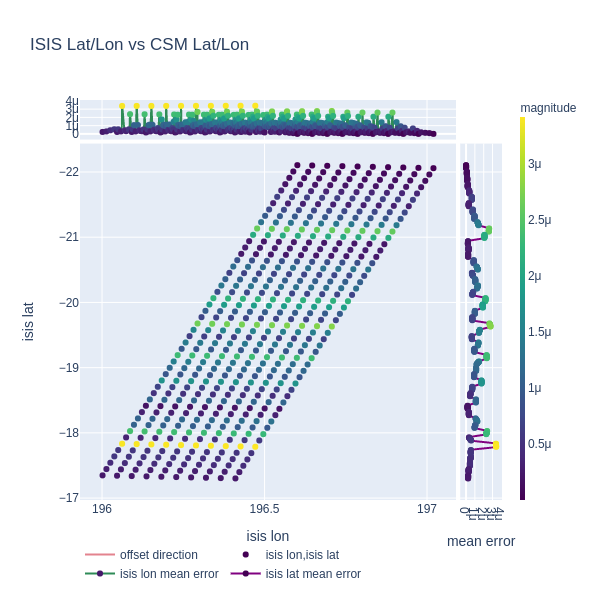

In [14]:
Image(isiscsm_plotlatlon.to_image())

In [15]:
isiscsm_latlondata[['diff lon', 'diff lat']].describe()

,diff lon,diff lat
count,5.000000e+02,5.000000e+02
mean,1.541672e-08,9.416045e-08
std,9.655292e-07,8.033224e-07
min,-2.612819e-06,-1.715237e-06
25%,-5.533798e-07,-3.466611e-07
50%,1.520183e-08,-7.787795e-09
75%,6.492479e-07,4.680268e-07
max,2.703826e-06,2.247407e-06


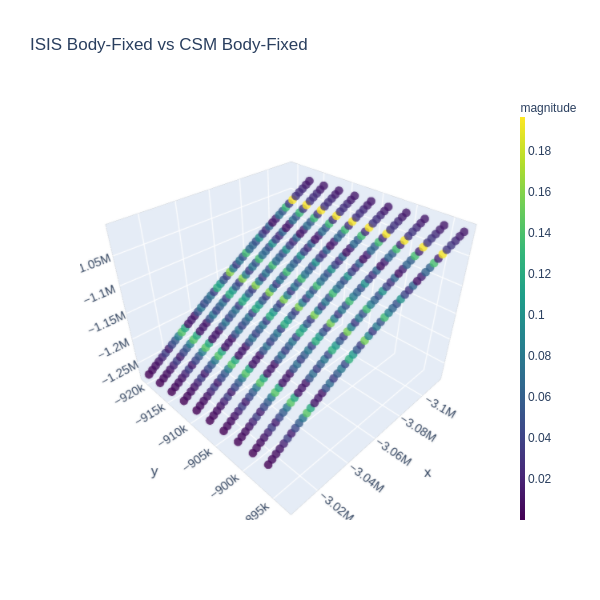

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,500.000000,500.000000
mean,0.430122,0.001443,-0.005236
std,1.792980,0.053693,0.044841
min,-3.136399,-0.137489,-0.125220
25%,-0.903798,-0.024371,-0.025939
50%,0.078052,0.000128,0.000427
75%,2.135347,0.034494,0.019290
max,3.141486,0.156871,0.096515
